# (Mini-bach) (Stochastic) Gradient Descent
## Catch up
* The PAC learnability analysis discussed in class (Lecture 2) assumed a finite set  of feasible mappings for a given inference rule. It is not only not clear how one can choose that set, but imposing no constraints on the functions in that set also prones to **overfit**.
* Machine learning does not limit the set of feasible mappings, but rather assumes a **parametric model** (weights) on the mapping f (·).
* It is rarely possible to guess the proper setting of the weights as done in class with the XOR example (Lecture 6), thus one must resort to **optimization**
mechanisms.
* The common *Gradient Descent* algorithem, given by
$\boldsymbol{\theta}_{j+1} ← \boldsymbol{\theta}_{j} - \mu_j∇_{\boldsymbol{\theta}}\mathcal{L}_\mathcal{D}(\boldsymbol{\theta}_{j})$, involves three main
  challenges:
  * Gradient Computation - numerically computing the gradients obeys full empirical risk computation anew for each parameter, which is quite computationally extensive, particularly when the number of parameters is large.
  * Empirical Risk Computation -  the empirical risk evaluates the individual loss measure for each training sample, repeated many times in the learning process for usually large datasets.
  * Sensitivity to Local Minimas - the algorithem stops when it reaches a point in which the gradient is zers. Complex objectives are rarely convex, and typically include local minimas, saddle points, and plateaus.
* The first challenge 1 is mitigated via **backporpagation**, with the rest two  
  are handled by replacing the gradient descent algorithm with its **stochastic** version.





In this example we compare the convergence profiles of stochastic gradient descent to (full) gradient descent. We will use the basic `numpy` (for calculations) and `matplotlib` (for plotting) packages.


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Random seed
seed = 100
np.random.seed(seed)
random.seed(seed)

## Data Generation

To make things tractable and simple to visualize, we consider the fitting of a linear function to data taken from a noisy linear setup.
Mathematically speaking, our data is generated from the following relationship:
\begin{equation}
s_t = \alpha \cdot x_t + n_t,
\end{equation}
where the input $x_t$ is uniformly distributed over $[0,1]$, and $n_t$ is additive Gaussian noise with mean value $\mu$ and variance $\sigma^2$.

In [2]:
data_size=500
alpha = 1.8
mu = 1
sigma = 1
# Creating the synthetic data set
x_train = np.random.rand(data_size, 1)
s_train = mu + alpha * x_train + sigma*np.random.randn(data_size, 1)

Let's see what this data looks like:



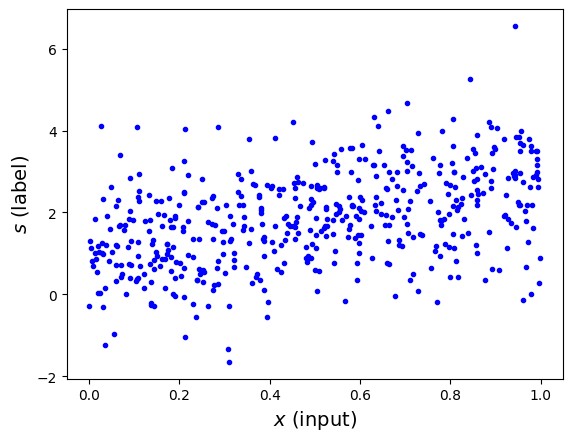

In [3]:
plt.plot(x_train, s_train, "b.")


plt.xlabel("$x$ (input)", fontsize=14)
plt.ylabel("$s$ (label)", rotation=90, fontsize=14)
plt.show()

## Parametric Model
We are training a simple linear model, which is given by:
\begin{equation}
f_{\boldsymbol{\theta}}= w_1 x + w_0, \qquad \boldsymbol{\theta} = [w_0, w_1].
\end{equation}
We use the squared-error loss, i.e.,
\begin{align}
l_{\rm mse}(f_{\boldsymbol{\theta}}, x, s) &= (s - f_{\boldsymbol{\theta}})^2 \\ &=  (s - w_1 x - w_0)^2.
\end{align}

In this case, the following function computes the average loss over a data set $\mathcal{D}$ stored in the vectors `x_data` and `s_data`:


In [4]:
def RiskLinReg(w0, w1, x_data,s_data):
    total_Error = 0
    for i in range(0, len(x_data)):
        total_Error += (s_data[i] - (w1 * x_data[i]+ w0)) ** 2
    return total_Error / float(len(x_data))

Let's see what this loss surface look like when taken over the entire data set:

In [5]:
# Generate grid of [w_0, w_1] values
w0=np.linspace(-8,8,1000)
w1=np.linspace(-8,8,1000)
X, Y = np.meshgrid(w0, w1)
# Compute loss for each grid point
Z = RiskLinReg(X, Y,x_train, s_train)
print(Z.min(), Z.max())

1.065053292140261 199.86379370718623


In [6]:
# Least Squares solution
XX = np.hstack([x_train, np.ones_like(x_train)])
print(XX.shape)
theta_star = np.dot(np.matmul(np.linalg.inv(np.matmul(XX.T, XX)), XX.T), s_train)
w_opt, b_opt = theta_star[0], theta_star[1]
print(w_opt, b_opt)

(500, 2)
[1.72311086] [0.9950571]


c:\Users\Simor\AppData\Local\Programs\Python\Python314\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


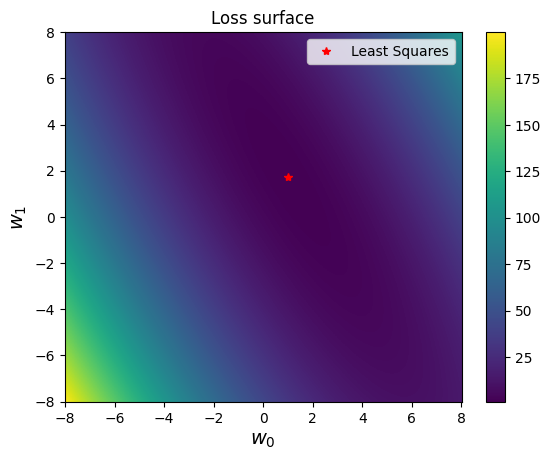

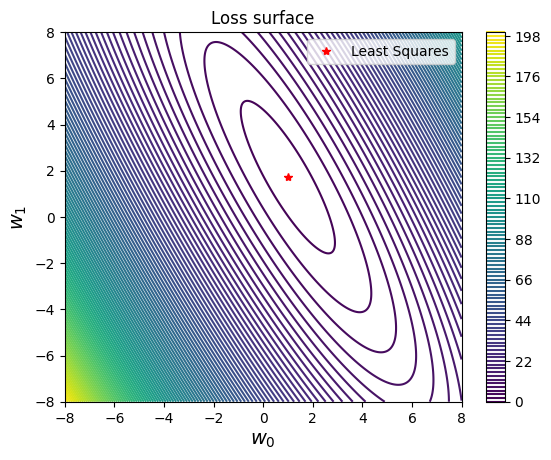

In [7]:
plt.pcolormesh(X, Y, Z)
plt.plot(b_opt, w_opt, 'r*', label="Least Squares")
plt.colorbar()
plt.xlabel("$w_0$", fontsize=14)
plt.ylabel("$w_1$", rotation=90, fontsize=14)
plt.title('Loss surface')
plt.legend()
plt.show()

plt.contour(X, Y, Z,100)
plt.plot(b_opt, w_opt, 'r*', label="Least Squares")
plt.colorbar()
plt.xlabel("$w_0$", fontsize=14)
plt.ylabel("$w_1$", rotation=90, fontsize=14)
plt.title('Loss surface')
plt.legend()
plt.show()

# Gradient Descent
We train the model using 40 iterations of full gradient descent.
Let us first compute the gradients:
$$
\begin{align}
\frac{\partial}{\partial w_0}l_{\rm mse}(f_{\boldsymbol{\theta}}, x, s) &= 2(w_1 x + w_0 - s), \\
\frac{\partial}{\partial w_1}l_{\rm mse}(f_{\boldsymbol{\theta}}, x, s) &= 2x(w_1 x + w_0 - s),
\end{align}
$$
which can be written as,
$$
\begin{equation}
\nabla_{\boldsymbol{\theta}}l_{\rm mse}(f_{\boldsymbol{\theta}}, x, s)=  
2\begin{bmatrix}
1\\
x
\end{bmatrix} ([1, \, x]
\begin{bmatrix}
w_0\\
w_1
\end{bmatrix}
- s) = 2\begin{bmatrix}
1\\
x
\end{bmatrix} ([1, \, x] {{\boldsymbol \theta}}-s).
\end{equation}
$$
This boils down to the following function:

In [8]:
def RiskLinRegGrad(W, x_data, s_data):
  xi = np.c_[np.ones(len(x_data)),x_data]  # padding x_train with ones and concatenate along the second axis (diemention: dim_data x 2)
  return 2 * xi.T.dot(xi.dot(W) - s_data)/len(s_data) # (diemention: [2 x dim_data] x [dim_data x 1] )

Now let's train the model using (stochastic) gradient descent. To that aim, we define random starting weights and the following function:


In [9]:
W0 = 0.01*np.random.randn(2,1)
n_epochs = 40
LearningRate = 0.05

def SGD(W0, x_train, s_train, minibatch_size, epochs=n_epochs):

  WSGD = W0
  WtrajectorySGD=np.array(W0)

  for j in range(epochs):
    # Shuffle the data in a random manner
    p = np.random.permutation(len(x_train))
    x_train = x_train[p]
    s_train = s_train[p]
    # Loop over data in each epoch
    for i in range(0, s_train.shape[0], minibatch_size):
      xi = x_train[i:i+minibatch_size]
      si = s_train[i:i+minibatch_size]
      # SGD update rule
      WSGD = WSGD - LearningRate * RiskLinRegGrad(WSGD,xi, si)

    # saving the trajectory to be visulalized later
    WtrajectorySGD=np.hstack((WtrajectorySGD,WSGD))
    if j <= 10 or j%10 == 0  or j%100 == 0 or j == n_epochs-1:
      print('Risk at epoch ',j, ' is ', RiskLinReg(WSGD[0], WSGD[1], x_train,s_train))

  return WSGD, WtrajectorySGD

## Full Gradient Descent
We can now run full gradient descent:

In [10]:
# Since each epoch is an iteration, we are using more epochs here
WGD, WtrajectoryGD = SGD(W0, x_train, s_train, len(x_train), n_epochs)

Risk at epoch  0  is  [3.91176932]
Risk at epoch  1  is  [3.25450594]
Risk at epoch  2  is  [2.75255962]
Risk at epoch  3  is  [2.36917809]
Risk at epoch  4  is  [2.07630636]
Risk at epoch  5  is  [1.85252851]
Risk at epoch  6  is  [1.68149659]
Risk at epoch  7  is  [1.55073129]
Risk at epoch  8  is  [1.45070646]
Risk at epoch  9  is  [1.37415025]
Risk at epoch  10  is  [1.3155116]
Risk at epoch  20  is  [1.13354062]
Risk at epoch  30  is  [1.11472917]
Risk at epoch  39  is  [1.1083211]


## Stochastic Gradient Descent
We can now run it with mini-batch size 1:

In [11]:
WSGD, WtrajectorySGD = SGD(W0, x_train, s_train, 1)

Risk at epoch  0  is  [1.11342901]
Risk at epoch  1  is  [1.18355115]
Risk at epoch  2  is  [1.06754382]
Risk at epoch  3  is  [1.06942778]
Risk at epoch  4  is  [1.08889943]
Risk at epoch  5  is  [1.11625208]
Risk at epoch  6  is  [1.10731517]
Risk at epoch  7  is  [1.20829429]
Risk at epoch  8  is  [1.13214257]
Risk at epoch  9  is  [1.10254497]
Risk at epoch  10  is  [1.49789187]
Risk at epoch  20  is  [1.06615003]
Risk at epoch  30  is  [1.19813229]
Risk at epoch  39  is  [1.14896805]


## Mini-batch SGD
And with mini-batch size of 20:

In [12]:
WMB_SGD, WtrajectoryMB_SGD = SGD(W0, x_train, s_train, 20)

Risk at epoch  0  is  [1.12422285]
Risk at epoch  1  is  [1.10599474]
Risk at epoch  2  is  [1.09437051]
Risk at epoch  3  is  [1.08497257]
Risk at epoch  4  is  [1.07910952]
Risk at epoch  5  is  [1.07771834]
Risk at epoch  6  is  [1.0734272]
Risk at epoch  7  is  [1.07144505]
Risk at epoch  8  is  [1.068608]
Risk at epoch  9  is  [1.06877409]
Risk at epoch  10  is  [1.06866667]
Risk at epoch  20  is  [1.0651714]
Risk at epoch  30  is  [1.06503235]
Risk at epoch  39  is  [1.06531807]


Let's see what the models learned look like:

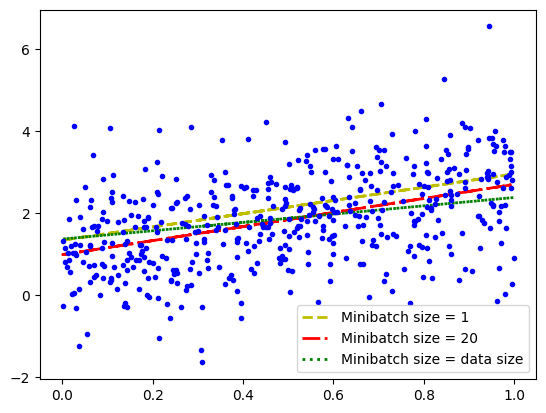

In [13]:
# Compute model outputs
s_hat = WGD[1]*x_train + WGD[0]
s_hatSGD = WSGD[1]*x_train + WSGD[0]
s_hatMB_SGD = WMB_SGD[1]*x_train + WMB_SGD[0]
# Visulize fitting of data
plt.plot(x_train,s_hatSGD,"y--", label='Minibatch size = 1', linewidth=2)
plt.plot(x_train,s_hatMB_SGD,"r-.", label='Minibatch size = 20', linewidth=2)
plt.plot(x_train,s_hat, "g:", label='Minibatch size = data size', linewidth=2)
plt.plot(x_train,s_train,"b.")
plt.legend()

# Backpropagation by PyTorch

We have just seen that training a parameterized model involves formulating the loss, compute gradients, and update the model weights via the MSGD rule.
Fortunately for us, PyTorch provides powerful libraries which do all that for us, and we essentially left to select:

*   A **loss** measure. In Lecture 1 we introduced with Error-Rate/Cross-Entropy for calssification and Squared-Error for regression. In particular, we use here the squared-error loss.  
*   An **optimizer**. So far we have only learned mini-batch SGD, and late on we will also see some of its variations.
* The structure of our parametrized **model**, e.g., a linear one. In particularm this also includes the selection of the *Output Layer*. In Lecture 6 we introdiced different types of those, depends on the task: linear unit for regression; sigmoid for detection; and softmax for classification.


We start with calling most important useful library of neural networks (torch).





In [14]:
import torch
from torch import nn, optim
torch.manual_seed(seed)

if torch.cuda.is_available(): # use GPU if available
  device = torch.device("cuda:0")
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.enabled = False
else:
  device = torch.device("cpu")
print(device) # it will be CPU unless you manually change the Runtime type to GPU

cpu


## Linear Model

In [15]:
# each Linear module has a weight and bias
in_features = 1
out_features = 1
model = nn.Linear(in_features, out_features)

print(model)
print(model.weight)
print(model.bias)

print(model.weight.grad)
print(model.bias.grad)

# auxilary function to extract the raw weights of the model
# note: to convert cuda:0 device type tensor to numpy, use Tensor.cpu() to copy the tensor to host memory first.
weights = lambda model : np.array([model.bias.item(), model.weight.item()]).reshape((2, 1))

# nn package also has different loss functions, we use MSE loss for our regression task
criterion = torch.nn.MSELoss()

# we use the optim package to apply SGD for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=LearningRate)

Linear(in_features=1, out_features=1, bias=True)
Parameter containing:
tensor([[-0.7767]], requires_grad=True)
Parameter containing:
tensor([0.6317], requires_grad=True)
None
None


## Training Function
We left to derive the training loop, comprised of:
  1.   Forward path - providing the output of the model to each batch, followed by computation of the loss value.
  2.   Backward path - computing the gradients and updating the weights using the built-in functions, *backward* and *step*, respectivly.

In [16]:
def SGD_torch(TrainInput, TrainLabel, model, minibatch_size):

  # cast and "send" to the defined device
  TrainInput = torch.from_numpy(TrainInput).to(device = device, dtype = torch.float32)
  TrainLabel = torch.from_numpy(TrainLabel).to(device = device, dtype = torch.float32)
  model = model.to(device)

  with torch.no_grad():
    model.bias.copy_(torch.from_numpy(W0[0]).to(device = device))
    model.weight.copy_(torch.from_numpy(W0[1]).to(device = device))


  WMB_torch = weights(model)
  WMB_trajectorySGD_torch = WMB_torch

  # Training
  for j in range(n_epochs):
    # Divide data into mini batches
    p = np.random.permutation(len(TrainInput))
    TrainInput = TrainInput[p]
    TrainLabel = TrainLabel[p]
    for i in range(0, TrainInput.shape[0], minibatch_size):
      # Feed forward to get the logits
      pred = model(TrainInput[i:i+minibatch_size])
      # Compute the training loss and accuracy
      loss = criterion(pred, TrainLabel[i:i+minibatch_size])

      # zero the gradients before running
      # the backward pass.
      optimizer.zero_grad()

      # Backward pass to compute the gradient
      # of loss w.r.t our learnable params.
      loss.backward()

      # Update params
      optimizer.step()

    # saving the trajectory to be visulalized later
    WMB_torch = weights(model)
    WMB_trajectorySGD_torch=np.hstack((WMB_trajectorySGD_torch, WMB_torch))

    if j <= 10 or j%10 == 0  or j%100 == 0 or j == n_epochs-1:
              print('Risk at epoch ',j, ' is ', RiskLinReg(WMB_torch[0], WMB_torch[1], x_train,s_train))

  return WMB_torch, WMB_trajectorySGD_torch


Let's train mini-batch SGD with torch and see what the model learned look like:

Risk at epoch  0  is  [1.11939049]
Risk at epoch  1  is  [1.10059875]
Risk at epoch  2  is  [1.09072496]
Risk at epoch  3  is  [1.08296717]
Risk at epoch  4  is  [1.07781111]
Risk at epoch  5  is  [1.07460243]
Risk at epoch  6  is  [1.0715985]
Risk at epoch  7  is  [1.0713586]
Risk at epoch  8  is  [1.06897845]
Risk at epoch  9  is  [1.06721168]
Risk at epoch  10  is  [1.06917638]
Risk at epoch  20  is  [1.0651774]
Risk at epoch  30  is  [1.06528646]
Risk at epoch  39  is  [1.0681679]
Parameter containing:
tensor([[1.7436]], requires_grad=True)
Parameter containing:
tensor([1.0406], requires_grad=True)
tensor([[-0.1319]])
tensor([-0.3273])


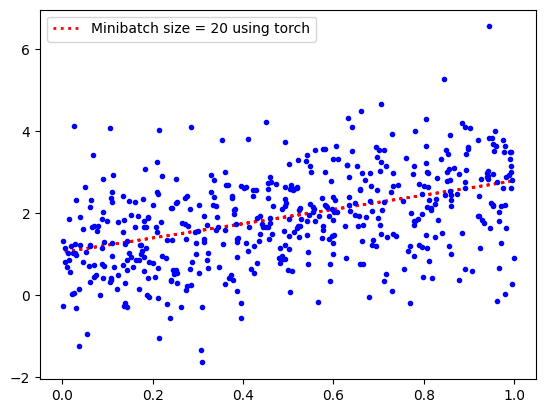

In [17]:
WMB_SGD_torch, WtrajectoryMB_SGD_torch = SGD_torch(x_train, s_train, model, 20)

print(model.weight)
print(model.bias)

print(model.weight.grad)
print(model.bias.grad)

# Compute model outputs
s_hatMB_SGD_torch = WMB_SGD_torch[1]*x_train + WMB_SGD_torch[0]
# Visulize fitting of data
plt.plot(x_train,s_hatMB_SGD_torch,"r:", label=f'Minibatch size = 20 using torch', linewidth=2)
plt.plot(x_train,s_train,"b.")
plt.legend()

# Summery
Now let's compare the trajectories on the loss surface:

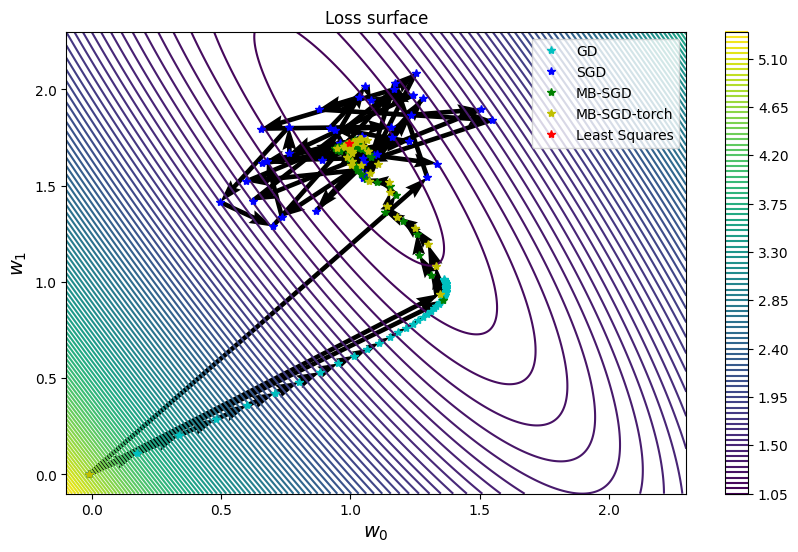

In [18]:
# Generate grid of [w_0, w_1] values
w0=np.linspace(-0.1,2.3,1000)
w1=np.linspace(-0.1,2.3,1000)
X, Y = np.meshgrid(w0, w1)
# Compute loss for each grid point
Z = RiskLinReg(X, Y,x_train, s_train)

# Loss surface:
plt.figure(figsize=(10,6))
plt.contour(X, Y, Z,100)
plt.colorbar()
plt.xlabel("$w_0$", fontsize=14)
plt.ylabel("$w_1$", rotation=90, fontsize=14)
plt.title('Loss surface')

# Trajectories:
# full GD (batch size = data size)
plt.plot(WtrajectoryGD[0,:],WtrajectoryGD[1,:],'c*',label='GD')
plt.quiver(WtrajectoryGD[0,:-1], WtrajectoryGD[1,:-1], WtrajectoryGD[0,1:]-WtrajectoryGD[0,:-1], WtrajectoryGD[1,1:]-WtrajectoryGD[1,:-1], scale_units='xy', angles='xy', scale=1)

# SGD (batch size = 1)
plt.plot(WtrajectorySGD[0,:],WtrajectorySGD[1,:],'b*',label='SGD')
plt.quiver(WtrajectorySGD[0,:-1], WtrajectorySGD[1,:-1], WtrajectorySGD[0,1:]-WtrajectorySGD[0,:-1], WtrajectorySGD[1,1:]-WtrajectorySGD[1,:-1], scale_units='xy', angles='xy', scale=1)

# minibatch SGD (batch size = minibatch size)
plt.plot(WtrajectoryMB_SGD[0,:],WtrajectoryMB_SGD[1,:],'g*',label='MB-SGD')
plt.quiver(WtrajectoryMB_SGD[0,:-1], WtrajectoryMB_SGD[1,:-1], WtrajectoryMB_SGD[0,1:]-WtrajectoryMB_SGD[0,:-1], WtrajectoryMB_SGD[1,1:]-WtrajectoryMB_SGD[1,:-1], scale_units='xy', angles='xy', scale=1)

# minibatch SGD (batch size = minibatch size) using torch
plt.plot(WtrajectoryMB_SGD_torch[0,:],WtrajectoryMB_SGD_torch[1,:],'y*',label='MB-SGD-torch')
plt.quiver(WtrajectoryMB_SGD_torch[0,:-1], WtrajectoryMB_SGD_torch[1,:-1], WtrajectoryMB_SGD_torch[0,1:]-WtrajectoryMB_SGD_torch[0,:-1], WtrajectoryMB_SGD_torch[1,1:]-WtrajectoryMB_SGD_torch[1,:-1], scale_units='xy', angles='xy', scale=1)

# Least Squares
plt.plot(b_opt,w_opt,'r*',label="Least Squares")
plt.legend()


Notice that, as expected, the higher the batch size, the stable is the risk decrease. In particular, for full gradient decent, the risk fucntion must decrese with each epch (reacll how the GD update-rule was derived).

It can be clearly seen in the trajectory plot that GD, SGD, and (torch) MB-SGD where all started form the same W0.
As in our case the risk is a convex function, it has no local miminima, but only a global minimum, to which gradient descent would accordingly converge.